In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import warnings
import string
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

In [2]:
data = pd.read_csv('data/news_political_dataset.csv')
data.sample(5)

headline  \
27075  Even As A Teenager, Obama Knew People Like Tru...   
16255  Debbie Reynolds And Carrie Fisher Remembered A...   
64022  'Sweet Charity' for Shirley MacLaine? Not So M...   
41746  Bob McDonnell Wants The Supreme Court To Do So...   
6465                                  The Toxic Tax Bill   

                                       short_description  is_political  
27075  "Respect came from what you did and not who yo...             1  
16255  R2-D2 and Dan Aykroyd celebrated the iconic ac...             0  
64022  Sachi has written an extraordinarily touching ...             0  
41746  The former governor-turned-felon is asking Chi...             1  
6465   Behind closed doors, Republicans in the U.S. S...             1

In [3]:
def clf_model(model_type, X_train, y_train, X_valid):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_valid)
    predicted_probab = model.predict_proba(X_valid)[:,1]
    return [predicted_labels,predicted_probab, model]

In [4]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_headline_text'] = data['short_description'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [6]:
MAX_FEATURES = 200
tfidf_model = TfidfVectorizer(max_features=MAX_FEATURES)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_headline_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

10  administration  already  also  always  america  american  another  \
0  0.0             0.0      0.0   0.0     0.0      0.0       0.0      0.0   
1  0.0             0.0      0.0   0.0     0.0      0.0       0.0      0.0   
2  0.0             0.0      0.0   0.0     0.0      0.0       0.0      0.0   
3  0.0             0.0      0.0   0.0     0.0      0.0       0.0      0.0   
4  0.0             0.0      0.0   0.0     0.0      0.0       0.0      0.0   

   around  away  ...  white  win  without  woman  work  world  would  year  \
0     0.0   0.0  ...    0.0  0.0      0.0    0.0   0.0    0.0    0.0   0.0   
1     0.0   0.0  ...    0.0  0.0      0.0    0.0   0.0    0.0    0.0   0.0   
2     0.0   0.0  ...    0.0  0.0      0.0    0.0   0.0    0.0    0.0   0.0   
3     0.0   0.0  ...    0.0  0.0      0.0    0.0   0.0    0.0    0.0   0.0   
4     0.0   0.0  ...    0.0  0.0      0.0    0.0   0.0    0.0    0.0   0.0   

   yet  york  
0  0.0   0.0  
1  0.0   0.0  
2  0.0   0.0  
3  0.0   0.0  
4  0.0   0.0  

[5 rows x 200 columns]

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['is_political'], test_size=0.2, random_state=42,stratify = data['is_political'])

confusion matrix: 
 [[6827  526]
 [3420 3128]]

accuracy:  0.7161355298179987

classification report: 
               precision    recall  f1-score   support

           0       0.67      0.93      0.78      7353
           1       0.86      0.48      0.61      6548

    accuracy                           0.72     13901
   macro avg       0.76      0.70      0.69     13901
weighted avg       0.76      0.72      0.70     13901


Area under ROC curve for validation set: 0.7514346971357402


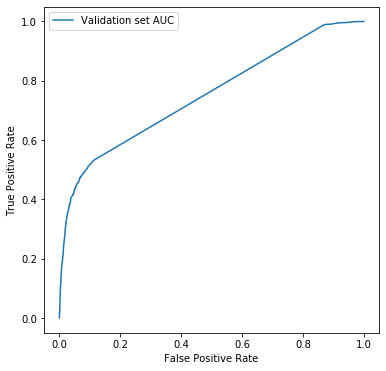

In [8]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=10,learning_rate=0.05,max_depth=18,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

In [9]:
word_importances = pd.DataFrame({'word':X_train.columns,'importance':model_xgb.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(4)

word  importance
178       trump    0.193803
136   president    0.104976
144  republican    0.082170
160       state    0.036298